In [51]:
import ee
# ee.Authenticate()
ee.Initialize()

In [258]:
import ipyleaflet
import numpy as np
import requests
import os
import pandas as pd
import rasterio
from rasterio.crs import CRS
import boto3
import geopandas as gpd
import glob
import geemap
import stateplane # Lookup State Plane by lat lon and convert
import osmnx as ox
from pandas_geojson import write_geojson
from rasterio import features

# Load cities data & choose city

In [2]:
## Load metro area boundaries
cities = gpd.read_file("data/Smart_Surfaces_metro_areas/smart_surfaces_urban_areas.shp")
print(cities)

    OBJECTID UACE10 GEOID10                               NAME10  \
0        558  42346   42346                      Jacksonville_FL   
1        608  80389   80389                           Seattle_WA   
2        684  15670   15670                     Charlotte_NC__SC   
3        714  71317   71317                      Portland_OR__WA   
4        816  56602   56602                             Miami_FL   
5        990  58600   58600                        Montgomery_AL   
6       1101  23824   23824                           Detroit_MI   
7       1584  09271   09271                    Boston_MA__NH__RI   
8       1625  77770   77770                      St_Louis_MO__IL   
9       1666  77068   77068                        Sacramento_CA   
10      2312  63217   63217          New_York__Newark_NY__NJ__CT   
11      2537  69076   69076          Philadelphia_PA__NJ__DE__MD   
12      2709  56116   56116                   Memphis_TN__MS__AR   
13      2834  22042   22042     Dallas__Fort_Wor

In [165]:
## Choose city of interest, use underscores instead of spaces
city = 'New_Orleans'

## Get city geometry
city_geom = cities.loc[cities['NAME10'].str.contains(city, case = False)]

# city_geom = cities.loc[cities['NAME10'] == city]
print(city_geom)

## Get centroid of city area 
centroid = city_geom.centroid

## Determine local state plane projection
proj = stateplane.identify(centroid.x, centroid.y)

In [85]:
## Create bounding box (0.007 is about half a mile in degrees)
bb = city_geom.buffer(0.007).bounds

west = bb.iat[0, 0]
south = bb.iat[0, 1]
east = bb.iat[0, 2]
north = bb.iat[0, 3]

bb_geom = ee.Geometry.BBox(west, south, east, north)

/var/folders/jn/2s8m6y5x09z9ysrcz_t9z2qw0000gq/T/ipykernel_51936/1589037119.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bb = city_geom.buffer(0.007).bounds


# ESA Worldcover

In [131]:
# Read ESA land cover (2021)
esa = ee.ImageCollection('ESA/WorldCover/v200')

# Clip to city of interest
esa_city = esa.filterBounds(bb_geom)

# ImageCollection to image
esa_city = esa_city.first()

# Reclassify raster to combine greenspace types

## [ND, Tree, Shrubland, Grassland, Cropland, Built up, Bare/sparse vegetation,
##  Snow/ice, Permanent water bodies, Herbaceous wetland, Mangroves, Moss and lichen]
FROM = [0, 10, 20, 30, 40, 50, 60, 80, 70, 90, 95, 100]

## [ND, Green, Green, Green, Green, Built up, Barren, Water, Water, Water, Water, Barren]
TO = [0, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 3]

# esa_city_rm = esa_city.remap(FROM, TO)

In [170]:
# Resample raster from 10-m to 1-m
esa_1m = esa_city.reproject(crs = "EPSG:"+proj, scale = 1)

# Export to Google Drive
# geemap.ee_export_image_to_drive(
#         esa_1m.toByte(), # use toByte() to reduce file size 
#         scale = 1, # 10 for native resolution, 50 for smaller file size 
#         description = 'ESA_1m',
#         region = bb_geom,
#         maxPixels = 5000000000
#     )

# Create city folder
out_dir = os.getcwd()
city_folder = out_dir + "/data/" + city
os.makedirs(city_folder)

################
## Download from Google Drive to city folder
################

In [188]:
################
## Need help with this loop, create variables for unknown # of tifs
# Read local raster

img_list = glob.glob(city_folder + '/*ESA_1m*')
# print(img_list)

esa_1 = rasterio.open(img_list[0])
esa_2 = rasterio.open(img_list[1])

print(esa_1.crs)

EPSG:26982


# OSM

## Open space

In [44]:
# open space OSM tags
## tags from https://github.com/wri/cities-cif/blob/main/notebooks/extract-layers/extract-OSMopenspace.ipynb
tags = {'leisure':['park', 'nature_reserve', 'common', 'playground', 'pitch', 'track'],
        'boundary':['protected_area','national_park']}

# use bounding box to get geodataframe of all OSM data on recreation sites/parks
RecSites = ox.features_from_bbox(bb['maxy'], bb['miny'], bb['maxx'], bb['minx'], tags)

# Drop points & lines
RecSites = RecSites[RecSites.geom_type != 'Point']
RecSites = RecSites[RecSites.geom_type != 'LineString'] 

Index(['ele', 'gnis:county_id', 'gnis:created', 'gnis:feature_id',
       'gnis:state_id', 'leisure', 'name', 'geometry', 'description', 'nodes',
       'NHD:ComID', 'NHD:FCode', 'NHD:FDate', 'NHD:FTYPE', 'NHD:RESOLUTION',
       'source', 'addr:city', 'addr:housenumber', 'addr:postcode',
       'addr:state', 'addr:street', 'barrier', 'sport', 'ways', 'alt_name',
       'boundary', 'historic', 'operator', 'operator:short', 'operator:type',
       'operator:wikidata', 'ownership', 'protect_class', 'protected',
       'protection_title', 'type', 'website', 'wikidata', 'wikipedia',
       'access', 'fee', 'indoor', 'hoops', 'surface', 'landuse',
       'opening_hours', 'area', 'lit', 'sport_1', 'golf', 'tourism',
       'wheelchair', 'playground:theme', 'foot', 'playground', 'lanes',
       'oneway', 'created_by', 'fence_type', 'old_name:es', 'old_name:fr',
       'name:es', 'name:fr', 'wikipedia:es', 'start_date', 'charge', 'phone',
       'dog', 'building', 'source_ref', 'old_name', 'am

<Axes: >

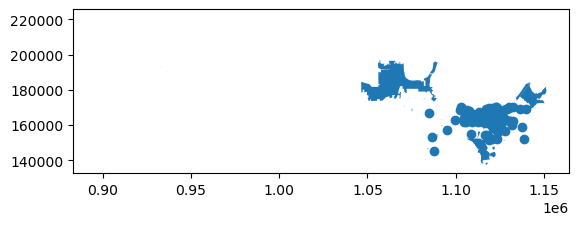

In [190]:
# Reproject to local state plane
# RecSites = RecSites.to_crs(proj)
# print(RecSites.crs)

RecSites.plot()

In [191]:
# Rasterize to match grid of esa 
geom = [shapes for shapes in RecSites.geometry]

# Rasterize vector using the shape and coordinate system of the raster
# all_touched = False means that only cells whose centroid is in the polygon are included
# https://pygis.io/docs/e_raster_rasterize.html
rasterized = rasterio.features.rasterize(geom,
                                out_shape = esa_1.shape,
                                fill = 0,
                                out = None,
                                transform = esa_1.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

In [196]:
# Write raster
with rasterio.open(
        city_folder + "/open_space.tif", "w",
        driver = "GTiff",
        crs = esa_1.crs,
        transform = esa_1.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = esa_1.width,
        height = esa_1.height) as dst:
    dst.write(rasterized, indexes = 1)

## Roads

In [260]:
# Highways OSM tags
## tags from Ludwig et al. 2021, https://www.mdpi.com/2220-9964/10/4/251
tags = {'highway':['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'residential', 'unclassified', 'motorway_link', 
        'trunk_link', 'primary_link', 'secondary_link', 'tertiary_link', 'living_street']}

# use bounding box to get geodataframe of all OSM data on recreation sites/parks
roads = ox.features_from_bbox(bb['maxy'], bb['miny'], bb['maxx'], bb['minx'], tags)

# Drop points 
roads = roads[roads.geom_type != 'Point']

################
## If there are polygons, cast them to lines
################

In [301]:
# Calculate average number of lanes per highway type (use the ceiling)
roads["highway"] = roads["highway"].astype(str)
roads["lanes"] = roads["lanes"].astype(float)
avg_lanes = roads.groupby('highway')['lanes'].mean()
avg_lanes = np.ceil(avg_lanes)

# Fill NaN values w/ avg values
# make a series with full substitutions (even if there are valid c2 values)
g = avg_lanes[roads.highway]
print(g)

# reset the index to match the dataframe
g.index = roads.index

# set the column values -- where non NaN take original; where NaN take from g
roads['lanes'] = roads['lanes'].where(lambda x: ~pd.isna(x), g)
print(roads['lanes'].head())

highway
residential    2.0
residential    2.0
residential    2.0
residential    2.0
residential    2.0
              ... 
primary        3.0
primary        3.0
primary        3.0
residential    2.0
residential    2.0
Name: lanes, Length: 24687, dtype: float64
element_type  osmid   
way           12649850    2.0
              12652385    2.0
              12653580    2.0
              12654440    2.0
              12654885    2.0
Name: lanes, dtype: float64


In [295]:
k = pd.Series([0,1,2,3,4,5], index=['a', 'b', 'c', 'd', 'e', 'f'])
print(k)

df = pd.DataFrame([{'c1': 'a', 'c2': None}, {'c1': 'a', 'c2': 5.0}, {'c1': 'b', 'c2': None}])
print(df)

# make a series with full substitutions (even if there are valid c2 values)
g = k[df.c1]
print(g)

# reset the index to match the dataframe
g.index = df.index
print(g.index)

# set the column values -- where non NaN take original; where NaN take from g
df['c2'] = df['c2'].where(lambda x: ~pd.isna(x), g)
print(df)

a    0
b    1
c    2
d    3
e    4
f    5
dtype: int64
  c1   c2
0  a  NaN
1  a  5.0
2  b  NaN
a    0
a    0
b    1
dtype: int64
RangeIndex(start=0, stop=3, step=1)
  c1   c2
0  a  0.0
1  a  5.0
2  b  1.0
